<a href="https://colab.research.google.com/github/dheerajponnaganti/Automated-content-moderator/blob/master/Automated_Content_Moderation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Automated Content Moderation**

---



The following python code will use the OS library to use Operating System libr
aries, giving you access to the file system, and the zipfile library allowing you to unzip the data.

In [1]:
import os
import zipfile

local_zip = '/content/dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/dataset')
zip_ref.close()
print("extracted check file system")

extracted check file system


The contents of the .zip are extracted to the base directory `'/content/dataset.zip'`, which in turn each contain `good` and `bad` subdirectories.

In short: The training set is the data that is used to tell the neural network model that 'this is what a good looks like', 'this is what a bad looks like' etc. 

One thing to pay attention to in this sample: We do not explicitly label the images as good or bad. If you remember with the handwriting example earlier, we had labelled 'this is a 1', 'this is a 7' etc.  Later you'll see something called an ImageGenerator being used -- and this is coded to read images from subdirectories, and automatically label them from the name of that subdirectory. So, for example, you will have a 'training' directory containing a 'good' directory and a 'bad' one. ImageGenerator will label the images appropriately for you, reducing a coding step. 

Let's define each of these directories:

In [0]:

 # Directory with our training bad pictures
train_bad_dir = os.path.join('/content/dataset/bad')

# Directory with our training good pictures
train_good_dir = os.path.join('/content/dataset/good')

Now, let's see what the filenames look like in the `good` and `bad` training directories:

In [3]:
train_bad_names = os.listdir(train_bad_dir)
print(train_bad_names[:10])

train_good_names = os.listdir(train_good_dir)
print(train_good_names[:10])

['shot 2.jpg', 'images - 2020-01-22T084243.247.jpg', 'images - 2020-01-22T083808.871 (2).jpg', '0CqK5516 (2).jpg', 'tmg-article_tall (3).jpg', 'd1 (2).JPG', 'ERrKab9WkAEJb1q.jpg', 'images (49).jpg', 'images (207).jpg', 'images (130).jpg']
['cats_00178.jpg', 'horse38-3.png', 'dogs_00252.jpg', 'dogs_00218.jpg', 'horse30-0.png', 'cats_00226.jpg', 'dogs_00166.jpg', 'dogs_00107.jpg', 'cats_00297.jpg', 'dogs_00143.jpg']


Let's find out the total number images in the directories:

In [4]:
print('total training bad images:', len(os.listdir(train_bad_dir)))
print('total training good images:', len(os.listdir(train_good_dir)))

total training bad images: 846
total training good images: 716


Now let's take a look at a few pictures to get a better sense of what they look like. First, configure the matplot parameters:

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

Now, display a batch of 8 starvation and 8 wound pictures. You can rerun the cell to see a fresh batch each time:

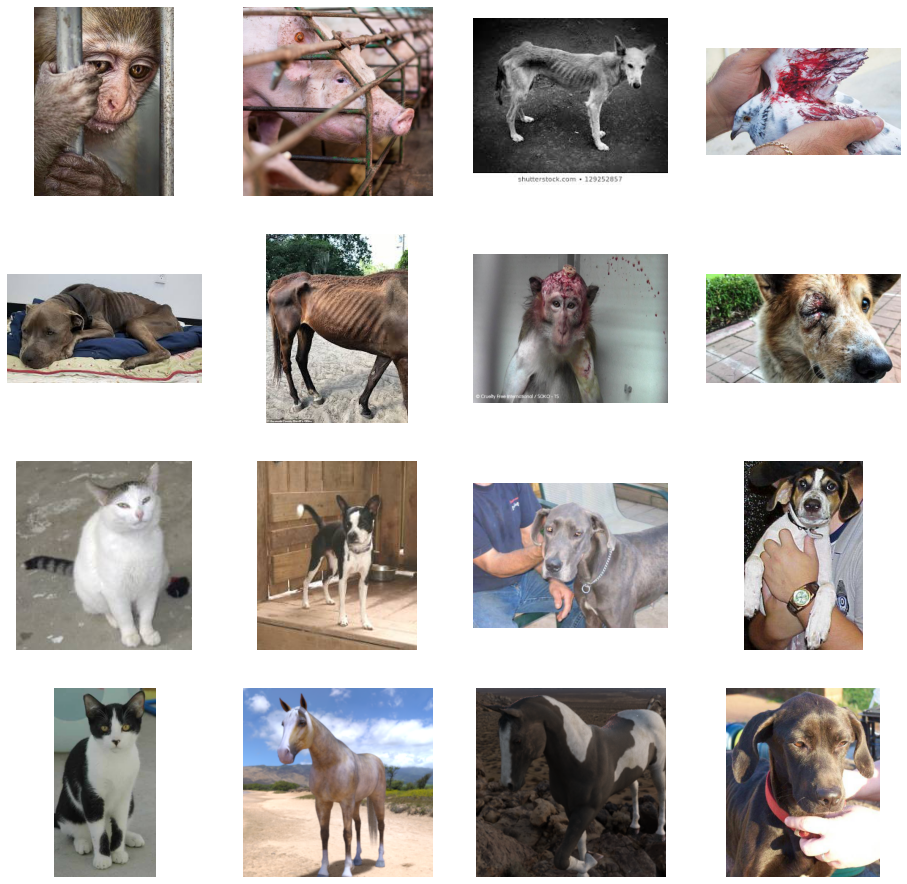

In [9]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_bad_pix = [os.path.join(train_bad_dir, fname) 
                for fname in train_bad_names[pic_index-8:pic_index]]
next_good_pix = [os.path.join(train_good_dir, fname) 
                for fname in train_good_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_bad_pix+next_good_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

## Building a Small Model from Scratch

---



But before we continue, let's start defining the model:

Step 1 will be to import tensorflow.


In [0]:
import tensorflow as tf

We then add convolutional layers as in the previous example, and flatten the final result to feed into the densely connected layers.

Finally we add the densely connected layers.

Note that because we are facing a two-class classification problem, i.e. a binary classification problem, we will end our network with a sigmoid activation, so that the output of our network will be a single scalar between 0 and 1, encoding the probability that the current image is class 1 (as opposed to class 0).


In [0]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('bad') and 1 for the other ('good')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

The model.summary() method call prints a summary of the NN 

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 33, 33, 64)       

The "output shape" column shows how the size of your feature map evolves in each successive layer. The convolution layers reduce the size of the feature maps by a bit due to padding, and each pooling layer halves the dimensions.

Next, we'll configure the specifications for model training. We will train our model with the binary_crossentropy loss, because it's a binary classification problem and our final activation is a sigmoid. (For a refresher on loss metrics, see the Machine Learning Crash Course.) We will use the rmsprop optimizer with a learning rate of 0.001. During training, we will want to monitor classification accuracy.

NOTE: In this case, using the RMSprop optimization algorithm is preferable to stochastic gradient descent (SGD), because RMSprop automates learning-rate tuning for us. (Other optimizers, such as Adam and Adagrad, also automatically adapt the learning rate during training, and would work equally well here.)


In [0]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

###Data Preprocessing

Let's set up data generators that will read pictures in our source folders, convert them to float32 tensors, and feed them (with their labels) to our network. We'll have one generator for the training images and one for the validation images. Our generators will yield batches of images of size 300x300 and their labels (binary).

As you may already know, data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network. (It is uncommon to feed raw pixels into a convnet.) In our case, we will preprocess our images by normalizing the pixel values to be in the [0, 1] range (originally all values are in the [0, 255] range).

In Keras this can be done via the keras.preprocessing.image.ImageDataGenerator class using the rescale parameter. This ImageDataGenerator class allows you to instantiate generators of augmented image batches (and their labels) via .flow(data, labels) or .flow_from_directory(directory). These generators can then be used with the Keras model methods that accept data generators as inputs: fit_generator, evaluate_generator, and predict_generator.

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        '/content/dataset',  # This is the source directory for training images
        target_size=(300, 300),  # All images will be resized to 150x150
        batch_size=128,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

Found 1562 images belonging to 2 classes.


###Training

Let's train for 15 epochs -- this may take a few minutes to run.

Do note the values per epoch.

The Loss and Accuracy are a great indication of progress of training. It's making a guess as to the classification of the training data, and then measuring it against the known label, calculating the result. Accuracy is the portion of correct guesses. 

In [0]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=8,  
      epochs=15,
      verbose=1)

Epoch 1/15
8/8 [==============================] - 93s 12s/step - loss: 0.8140 - acc: 0.4805
Epoch 2/15
8/8 [==============================] - 74s 9s/step - loss: 0.6790 - acc: 0.5622
Epoch 3/15
8/8 [==============================] - 83s 10s/step - loss: 0.6853 - acc: 0.5811
Epoch 4/15
8/8 [==============================] - 91s 11s/step - loss: 0.6631 - acc: 0.6055
Epoch 5/15
8/8 [==============================] - 83s 10s/step - loss: 0.6878 - acc: 0.6074
Epoch 6/15
8/8 [==============================] - 76s 9s/step - loss: 0.6138 - acc: 0.6703
Epoch 7/15
8/8 [==============================] - 90s 11s/step - loss: 0.7294 - acc: 0.6348
Epoch 8/15
8/8 [==============================] - 75s 9s/step - loss: 0.6061 - acc: 0.6898
Epoch 9/15
8/8 [==============================] - 83s 10s/step - loss: 0.5928 - acc: 0.7126
Epoch 10/15
8/8 [==============================] - 82s 10s/step - loss: 0.5751 - acc: 0.6996
Epoch 11/15
8/8 [==============================] - 84s 10s/step - loss: 0.6064 - a

###Running the Model

Let's now take a look at actually running a prediction using the model. This code will allow you to choose 1 or more files from your file system, it will then upload them, and run them through the model, giving an indication of whether the object is good or bad.

In [0]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(300, 300))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is good")
  else:
    print(fn + " is bad")

Using TensorFlow backend.


Saving 0_und-at-the-clandestine-dog-fighting-ring-Image-FocusOn-News.jpg to 0_und-at-the-clandestine-dog-fighting-ring-Image-FocusOn-News.jpg
Saving 1 Investigations_MPI Picture 9.jpg to 1 Investigations_MPI Picture 9.jpg
Saving 1d558e0a743a117d4c07ecee9b897786--the-next-to-the.jpg to 1d558e0a743a117d4c07ecee9b897786--the-next-to-the.jpg
Saving 1-s2.0-S0378874106001358-pl1.jpg to 1-s2.0-S0378874106001358-pl1.jpg
Saving 2edc2b1c9f87d1756b12f06e018e0309.jpg to 2edc2b1c9f87d1756b12f06e018e0309.jpg
Saving 2EtZp.jpg to 2EtZp.jpg
Saving 06da7e5759dc142d8883ad2681ca9184.jpg to 06da7e5759dc142d8883ad2681ca9184.jpg
Saving 9c7a4cf4de62702668602442213da279.jpg to 9c7a4cf4de62702668602442213da279.jpg
Saving 34b4c06eda70ded11e2eb25f288914de.jpg to 34b4c06eda70ded11e2eb25f288914de.jpg
Saving 44d4o6zzj7b01.jpg to 44d4o6zzj7b01.jpg
Saving 189f8060-db00-11e9-a57f-09ab2da8ed83.jpg to 189f8060-db00-11e9-a57f-09ab2da8ed83.jpg
Saving 314.jpg to 314.jpg
Saving 770f3b18ade0cb3e6515033d1273124f.jpg to 770f3b1

### Visualizing Intermediate Representations

To get a feel for what kind of features our convnet has learned, one fun thing to do is to visualize how an input gets transformed as it goes through the convnet.

Let's pick a random image from the training set, and then generate a figure where each row is the output of a layer, and each image in the row is a specific filter in that output feature map. Rerun this cell to generate intermediate representations for a variety of training images.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


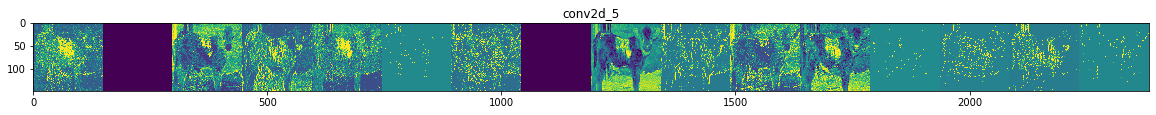

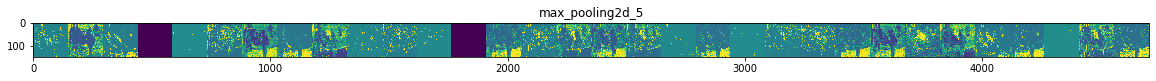

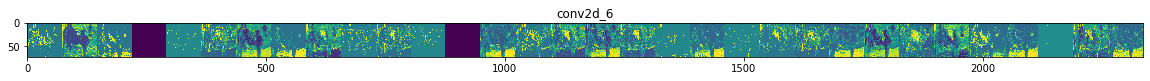

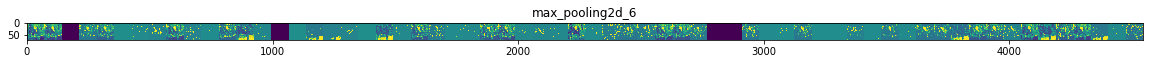

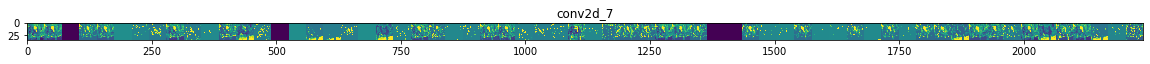

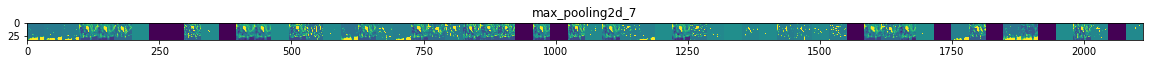

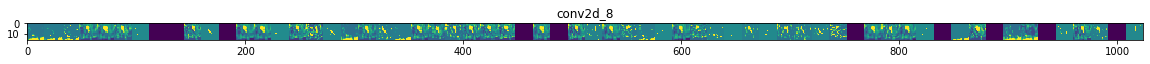

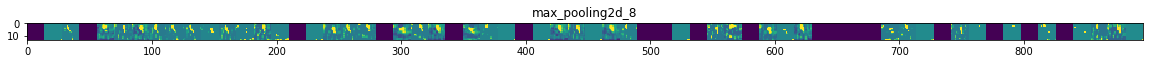

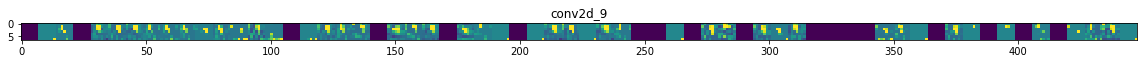

In [0]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
# Let's prepare a random input image from the training set.
bad_img_files = [os.path.join(train_bad_dir, f) for f in train_bad_names]
good_img_files = [os.path.join(train_good_dir, f) for f in train_good_names]
img_path = random.choice(bad_img_files + good_img_files)

img = load_img(img_path, target_size=(300, 300))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

As you can see we go from the raw pixels of the images to increasingly abstract and compact representations. The representations downstream start highlighting what the network pays attention to, and they show fewer and fewer features being "activated"; most are set to zero. This is called "sparsity." Representation sparsity is a key feature of deep learning.


These representations carry increasingly less information about the original pixels of the image, but increasingly refined information about the class of the image. You can think of a convnet (or a deep network in general) as an information distillation pipeline.

## Clean Up

Run the following cell to terminate the kernel and free memory resources:

In [0]:
import signal
os.kill(os.getpid(), signal.SIGKILL)